# Ship Detection Through Aerial Images

## Importing various librairies

In [1]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.io import imread
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable()
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
%matplotlib inline


### Hyperparameters to be tuned

In [2]:
gc.collect()

46

In [3]:
IMG_SCALING = (3, 3)
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'

### Sample reading an image
We read an image in dataset and notice its size

In [4]:
from matplotlib import image
img = image.imread("/kaggle/input/airbus-ship-detection/train_v2/000155de5.jpg")
scale_percent = 100
width = int(img.shape[0] * scale_percent / 100)
height = int(img.shape[1]* scale_percent / 100)
# width = 512
# height = 512
dim = (width, height)
batch_size = 128
dim

(768, 768)

### Encoding and decoding in Run Length encoding.
The given dataset is in run length encoding to save memory. We develop methods to encode and decode in run length encoding i.e. Mask->RLE and RLE->Mask

In [5]:
# Data Preprocessing

# RLE Encoding
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# RLE Decoding
def mask_ship(s):
#     if (np.isnan(s)):
#         return np.zeros((768,768))
    if (type(s)!= str):
        return np.zeros((768,768))
    s = s.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -=1
    ends = starts+lengths
    img = np.zeros((768*768,),dtype = np.uint8)
    for lo,hi in zip(starts,ends):
        img[lo:hi] = 1.0
    return img.reshape((768,768)).T

# Overlaying masks to create as single mask
def Overlay_masks(mask_list):
    all_masks = np.zeros((768, 768), dtype =np.uint8)
    if isinstance(mask_list,float):
        return all_masks
    for mask in mask_list:
        if isinstance(mask, str):
            all_masks |= mask_ship(mask)       
    return all_masks.astype(np.float64)

# Coloured Mask
def Overlay_masks_col(mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(mask_list)+x+1) / (len(mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * mask_ship(mask)
    return all_masks

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

### Reading The CSV file
We read the train_ship_segmentation csv file using pandas as pandas is one of the most efficient tools for data preprocessing. We check the details of the csv file loaded.

In [6]:
train_data = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
# Checking for duplicate entries
print(train_data['ImageId'].duplicated().any())
test_data = pd.read_csv("/kaggle/input/airbus-ship-detection/sample_submission_v2.csv")
# Columns of training data
print(train_data.columns)
# Total number of rows in data
print(len(train_data))

True
Index(['ImageId', 'EncodedPixels'], dtype='object')
231723


1. ### Checking the data properties(Exploratory Data Analysis)
In this  we check the number of ships occuring in a image distribution. We check the total number of images without any ship and try to come up with strategies to address the skewness(if any) of the data

The total number of images which are not empty is  42556
The total number of ships in all these images is  81723
The total number of images which are empty is  150000 out of total  192556 images


,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,4fde25a38.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


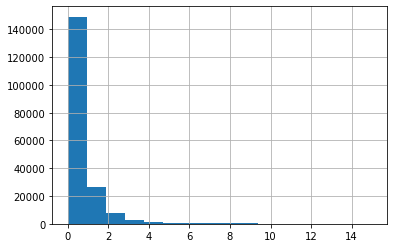

In [7]:
not_empty = pd.notna(train_data['EncodedPixels']) # Images which are having atleast one ship
print("The total number of images which are not empty is ",train_data[not_empty]["ImageId"].nunique())
print("The total number of ships in all these images is ",not_empty.sum())

print("The total number of images which are empty is ",(~not_empty).sum(),"out of total ", train_data["ImageId"].nunique(),"images")
# ship_dir = '../input'
# train_image_dir = os.path.join(ship_dir, 'train_v2')
train_data['ships'] = train_data['EncodedPixels'].apply(lambda x: 1 if isinstance(x,str) else 0)
unique_img_ids = train_data.groupby("ImageId").agg({'ships':'sum'}).reset_index()
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join('/kaggle/input/airbus-ship-detection/train_v2/', 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 55] # keep only +50kb files . Below 50Kb images are corrupt
unique_img_ids['ships'].hist(bins = unique_img_ids['ships'].max()+1)
train_data.drop(['ships'], axis = 1, inplace = True)
# train_data.dropna(inplace = True)
train_data.describe()

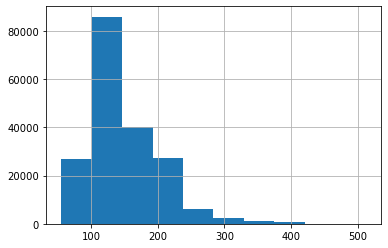

In [8]:
unique_img_ids['file_size_kb'].hist()
unique_img_ids.drop(['file_size_kb'],axis = 1, inplace = True)

### High Skewness of the data
As can be seen the data is highly skewed with 150000 images having no ship in a total dataset of 192556 images. We will downsample our dataset so that the number of ships belonging to each class is roughly equal.

12761 masks


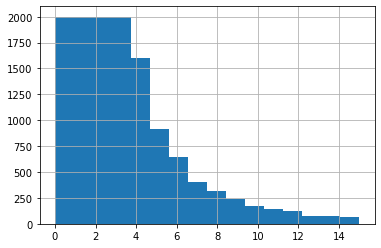

In [9]:
# Undersampling as most of the images do not contain any ships
def Downsample(df,samples_per_group):
    new_train_df = df.groupby('ships').apply(lambda x: x.sample(samples_per_group) if len(x)>samples_per_group else x)
    return new_train_df
train_data_undersampled = Downsample(unique_img_ids,2000)
train_data_undersampled['ships'].hist(bins=train_data_undersampled['ships'].max()+1)
print(train_data_undersampled.shape[0], 'masks')

### Checking RLE Encoding working
We check the correctness of our implemented methods. We convert given RLE to mask and then encode that mask to RLE and finally convert the RLE back to the mask and check the two masks are same or not
i.e. RLE->Image$_0$->RLE->Image$_1$. We check Image$_0$ == Image$_1$


0.0 difference


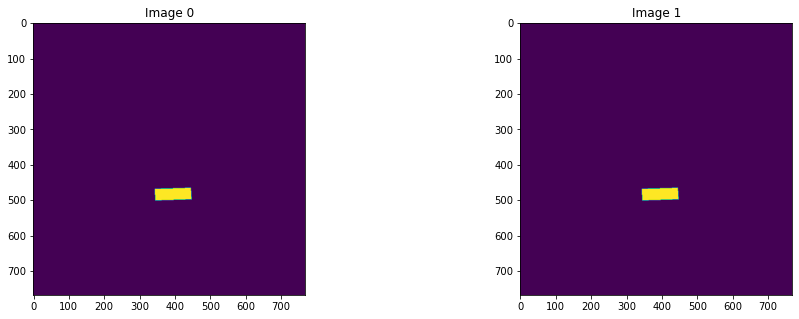

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
rle_0 = train_data.query('ImageId=="000155de5.jpg"')['EncodedPixels']
img_0 = Overlay_masks(rle_0)
ax1.imshow(img_0)
ax1.set_title('Image 0')
rle_1 = multi_rle_encode(img_0)
img_1 = Overlay_masks(rle_1)
ax2.imshow(img_1)
ax2.set_title('Image 1')
img_c = Overlay_masks_col(rle_0)
print(np.sum(np.abs(img_0 - img_1)), 'difference')

### Splitting the dataset into training and validation sets
In this we split our training data set into training set and validation set in the ration of 80% :: 20%

In [11]:
from sklearn.model_selection import train_test_split
train_masks,val_masks = train_test_split(train_data_undersampled,test_size = 0.2,stratify = train_data_undersampled['ships'])
train_masks = pd.merge(train_data, train_masks)
val_masks = pd.merge(train_data, val_masks)
print("Train :", len(train_masks), 'masks and Validation :', len(val_masks),"masks")
print(train_masks.isnull().values.any())

Train : 35223 masks and Validation : 8807 masks
True


### Image Generators
We create a class of image generators which take RLE into account and inbuilt image generators of keras

In [12]:
from keras.preprocessing.image import ImageDataGenerator
class CustomImageGenClass:
    def __init__(self,df,batch_size):
        self.image_gen = self.image_gen(df,batch_size)
        self.AugGen = self.AugGenerator()
    def image_gen(self,df,batch_size):
        labels = list(df.groupby("ImageId"))
        X = []
        Y = []
        for img_id,mask_rle in labels:
            img = imread('/kaggle/input/airbus-ship-detection/train_v2/'+img_id)
            img = img[::3,::3]# rescaling
            mask = np.expand_dims(Overlay_masks(mask_rle['EncodedPixels'].values),axis = -1)
            mask = mask[::3,::3]
#             print(img.shape, mask.shape)
            assert img.shape == (256,256,3)
            assert mask.shape == (256,256,1)
            X += [img]
            Y += [mask]
            if len(Y)>=batch_size:
                yield(np.stack(X,0)/255.0, np.stack(Y,0))
                X = []
                Y = []
    def AugGenerator(self):
        args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
        img_gen = ImageDataGenerator(**args)
        mask_gen = ImageDataGenerator(**args)
        for x_t, y_t in self.image_gen:
            g_x = img_gen.flow(255*x_t, 
                             batch_size = x_t.shape[0], 
                             seed = 1, 
                             shuffle=True)
            g_y = mask_gen.flow(y_t, 
                             batch_size = x_t.shape[0], 
                             seed = 1, 
                             shuffle=True)

            yield next(g_x)/255.0, next(g_y)
        
        

In [13]:
Train_Generator = CustomImageGenClass(train_masks,BATCH_SIZE)
train_x, train_y = next(Train_Generator.image_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())
Test_Generator = CustomImageGenClass(val_masks,900)
val_x, val_y = next(Test_Generator.image_gen)


x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0.0 1.0


In [14]:
gc.collect()

20

### Model
We create a U-net model

In [15]:
# def model(dim = dim):
    

In [16]:
# class DataGenerator(keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, labels, batch_size=32, dim=(192,192), n_channels=1,
#                  n_classes=2, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size,*self.dim,1))

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             img = cv2.imread('/kaggle/input/airbus-ship-detection/train_v2/' + ID)
#             X[i,] = cv2.resize(img,dsize = dim)

#             # Store class
#             s = self.labels[ID]
#             img = Overlay_masks(s)
#             y[i,] = cv2.resize(img, dsize = dim).reshape((*dim,1))

#         return X, y    

In [17]:
# params = {'dim': dim,
#           'batch_size': batch_size,
#           'n_classes': 2,
#           'n_channels': 3,
#           'shuffle': True}

# # Datasets
# # all_groups = list(train_data.groupby("ImageId"))
# # print(all_groups[3][1]['EncodedPixels'])
# partition = train_data["ImageId"]
# labels = train_data[["ImageId","EncodedPixels"]].set_index("ImageId")["EncodedPixels"]
# # # Generators
# training_generator = DataGenerator(partition, labels, **params)
# # validation_generator = DataGenerator(partition['validation'], labels, **params)

In [18]:
# # Pre-process the images by normalizing,zooming and flipping.
# data_gen_args = dict(rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         validation_split=0.15)
# img_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         validation_split=0.15)
# mask_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         validation_split=0.15,preprocessing_function = mask_ship)

# # Do not pre-process the test images
# test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# # Load in the data from the folder by using the file names from the dataframe.
# seed = 786
# train_generator = img_datagen.flow_from_dataframe(
#         dataframe=train_data,
#         directory='/kaggle/input/airbus-ship-detection/train_v2/',
#         x_col="ImageId",
#         target_size=dim,
#         batch_size=batch_size,
#         subset='training',seed = seed)
# mask_generator = mask_datagen(dataframe=train_data,
#         directory='/kaggle/input/airbus-ship-detection/train_v2/',
#         x_col="ImageId",
#         target_size=dim,
#         batch_size=batch_size,
#         subset='training',seed = seed)
# validation_generator = train_datagen.flow_from_dataframe(
#         dataframe=train_data,
#         directory='/kaggle/input/airbus-ship-detection/train_v2/',
#         x_col="ImageId",
#         y_col=['EncodedPixels'],
#         target_size=dim,
#         batch_size=batch_size,
#         class_mode='raw',
#         subset='validation')

# test_generator = test_datagen.flow_from_dataframe(
#         dataframe=test_data,
#         directory='/kaggle/input/airbus-ship-detection/test_v2/',
#         x_col="ImageId",
#         y_col=None,
#         target_size=dim,
#         batch_size=batch_size,
#         class_mode=None)

In [19]:
# def model(input_shape):
#     X_input=keras.Input(input_shape)
#     # Downsampling
#     X = keras.layers.Conv2D(8, (3, 3), strides = (1, 1), name = 'conv1', padding = 'valid',activation ='relu')(X_input)
#     X = keras.layers.Conv2D(8, (3, 3), strides = (1, 1), name = 'conv2', padding = 'valid',activation ='relu')(X)
#     Save1 = keras.layers.Conv2D(8,(3,3),strides = (1,1), name = 'Save1', padding = 'valid')(X)
# #     Save1 = X
    
#     X = keras.layers.MaxPooling2D((2, 2),strides = (2,2), name='max_pool_0')(X)
    
#     X = keras.layers.Conv2D(16, (3, 3), strides = (1, 1), name = 'conv3', padding = 'valid',activation ='relu')(X)
#     X = keras.layers.Conv2D(16, (3, 3), strides = (1, 1), name = 'conv4', padding = 'valid',activation ='relu')(X)
    
#     Save2 = keras.layers.Conv2D(32,(4,4),strides = (1,1), name = 'Save2_1', padding = 'valid')(X)
#     Save2 = keras.layers.Conv2D(32,(4,4),strides = (1,1), name = 'Save2_2', padding = 'valid')(Save2)

#     X = keras.layers.MaxPooling2D((2,2),strides = (2,2), name = 'max_pool_1' )(X)
    
#     X = keras.layers.Conv2D(32, (3,3),strides = (1,1), name = 'conv5', padding = 'valid', activation ='relu')(X)
#     X = keras.layers.Conv2D(32,(4,4), strides = (1,1), name = 'conv6', padding ='valid', activation = 'relu')(X)
#     Save3 = keras.layers.Conv2D(32,(3,3),strides = (1,1), name = 'Save3_1', padding = 'valid')(X)
#     Save3 = keras.layers.Conv2D(32,(3,3),strides = (1,1), name = 'Save3_2', padding = 'valid')(Save3)
    
#     X = keras.layers.MaxPooling2D((2,2), strides = (2,2), name = 'max_pool_2')(X)
    
#     X = keras.layers.Conv2D(64,(3,3), strides = (1,1), name = 'conv7',padding = 'valid',activation = 'relu')(X)
#     X = keras.layers.Conv2D(64, (3,3),strides = (1,1), name = 'conv8', padding = 'valid', activation = 'relu')(X)
    
# #     Save4 = keras.layers.ZeroPadding2D(padding = (3,3))(X)
#     Save4 = keras.layers.Conv2D(64, (9,9), strides = (1,1), name = 'Save4', padding = 'valid')(X)
    
    
#     X = keras.layers.MaxPooling2D((2,2), strides = (2,2), name = 'max_pool_3')(X)
    
#     X = keras.layers.Conv2D(128,(3,3), strides = (1,1), name = 'conv9',padding = 'valid',activation = 'relu')(X)
#     X = keras.layers.Conv2D(64, (3,3), strides = (1,1), name = 'conv10', padding = 'valid', activation = 'relu')(X)
# #     # Upsampling
#     X = keras.layers.UpSampling2D(size = (2,2))(X)
#     X = keras.layers.Concatenate(axis = -1)([Save4,X])
    
#     X = keras.layers.Conv2D(64,(3,3), strides = (1,1), name = 'conv11',padding = 'same',activation = 'relu')(X)
#     X = keras.layers.Conv2D(32,(3,3), strides = (1,1), name = 'conv12',padding = 'same',activation = 'relu')(X)
    
#     X = keras.layers.UpSampling2D(size = (2,2))(X)
#     # (160, 160, 160)
#     X = keras.layers.ZeroPadding2D(padding = (10,10))(X)
#     # (180, 180,256)
#     X = keras.layers.Concatenate(axis = -1)([Save3,X])
    
#     X = keras.layers.Conv2D(32,(3,3), strides = (1,1), name = 'conv13',padding = 'valid',activation = 'relu')(X)
#     X = keras.layers.Conv2D(16,(3,3), strides = (1,1), name = 'conv14',padding = 'valid',activation = 'relu')(X)
    
    
#     X = keras.layers.UpSampling2D(size = (2,2))(X)
#     X = keras.layers.ZeroPadding2D(padding = (10,10))(X)
#     X = keras.layers.Concatenate(axis = -1)([Save2,X])
    
#     X = keras.layers.Conv2D(16,(3,3), strides = (1,1), name = 'conv15',padding = 'valid',activation = 'relu')(X)
#     X = keras.layers.Conv2D(8,(3,3), strides = (1,1), name = 'conv16',padding = 'valid',activation = 'relu')(X)
    
    
#     X = keras.layers.UpSampling2D(size = (2,2))(X)
#     X = keras.layers.ZeroPadding2D(padding = (13,13))(X)
#     X = keras.layers.Concatenate(axis = -1)([Save1,X])
#     X = keras.layers.ZeroPadding2D(padding = (5,5))(X)
    
#     X = keras.layers.Conv2D(8,(3,3), strides = (1,1), name = 'conv17',padding = 'valid',activation = 'relu')(X)
#     X = keras.layers.Conv2D(8,(3,3), strides = (1,1), name = 'conv18',padding = 'valid',activation = 'relu')(X)
#     X = keras.layers.Conv2D(1,(1,1), strides = (1,1), name = 'conv19',padding = 'valid',activation = 'relu')(X)
#     X  = keras.layers.Softmax()(X)
#     model = keras.models.Model(inputs = X_input, outputs = X, name='model')

#     return model

In [20]:
from keras import models, layers
NET_SCALING = (1,1)
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(train_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 256, 256, 3)  0           average_pooling2d[0][0]          
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          gaussian_noise[0][0]             
______________________________________________________________________________________________

In [21]:
# from keras.utils.vis_utils import plot_model
# plot_model(seg_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def iou(y_true, y_pred, eps=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)
def oneHotcustomLoss(yTrue, yPred):
    #weights = {0: 1, 1:155}
    weighted = (K.argmax(yTrue) * 500) + 1
    #print(weighted)
    return keras.losses.binary_crossentropy(yTrue, yPred) * K.cast(weighted, np.float32)
def binary_iou_focal_loss(gamma=2, alpha=0.25):
    """
    Binary form of focal loss.
    适用于二分类问题的focal loss
    
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        eps=1e-6
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
        loss1=1-K.mean( (intersection + eps) / (union + eps), axis=0)
        
        loss2=loss1+focal_loss
        
        return K.mean(loss2)
    return binary_focal_loss_fixed


In [23]:
# def oneHotcustomLoss(yTrue, yPred):
#     #weights = {0: 1, 1:155}
#     weighted = (keras.backend.argmax(yTrue)*400) + 1
#     #print(weighted)
#     return keras.losses.binary_crossentropy(yTrue, yPred) * keras.backend.cast(weighted,np.float32)

In [24]:
gc.collect()

644

In [25]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)
    
early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint,  reduceLROnPlat]

In [26]:
MAX_TRAIN_STEPS = 9
BATCH_SIZE = 40
MAX_TRAIN_EPOCHS = 10
def fit():
    Train_Generator = CustomImageGenClass(train_masks,BATCH_SIZE)
    seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=iou, metrics=['binary_accuracy'])
    
    loss_history = [seg_model.fit_generator(Train_Generator.AugGen,
                                 steps_per_epoch=9,
                                 epochs=99,
                                 validation_data=(val_x, val_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.2:
        break

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/99
9/9 [==============================] - 23s 2s/step - loss: -0.0056 - binary_accuracy: 0.4574 - val_loss: -0.0057 - val_binary_accuracy: 0.0772

Epoch 00001: val_loss improved from inf to -0.00567, saving model to seg_model_weights.best.hdf5
Epoch 2/99
9/9 [==============================] - 14s 2s/step - loss: -0.0066 - binary_accuracy: 0.6553 - val_loss: -0.0058 - val_binary_accuracy: 0.0546

Epoch 00002: val_loss improved from -0.00567 to -0.00585, saving model to seg_model_weights.best.hdf5
Epoch 3/99
9/9 [==============================] - 15s 2s/step - loss: -0.0117 - binary_accuracy: 0.6401 - val_loss: -0.0064 - val_binary_accuracy: 0.0825

Epoch 00003: val_loss improved from -0.00585 to -0.00635, saving model to seg_model_weights.best.hdf5
Epoch 4/99
9/9 [==============================] - 14s 2s/step - loss: -0.0542 - binary_accuracy: 0.5948 - val_loss: -0.0097 - val_binary_accuracy: 0.1785

Epoch 00004: val_loss improved from -0.00635 to -0.00968, saving model to seg_m

In [27]:
gc.collect()

822

In [28]:
# if IMG_SCALING is not None:
#     fullres_model = models.Sequential()
#     fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
#     fullres_model.add(seg_model)
#     fullres_model.add(layers.UpSampling2D(IMG_SCALING))
# else:
#     fullres_model = seg_model
# fullres_model.save('fullres_model.h5')



In [29]:
# def raw_prediction(img, path='/kaggle/input/airbus-ship-detection/train_v2/'):
#     c_img = imread(os.path.join(path, c_img_name))
#     c_img = np.expand_dims(c_img, 0)/255.0
#     cur_seg = fullres_model.predict(c_img)[0]
#     return cur_seg, c_img[0]

# def smooth(cur_seg):
#     return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

# def predict(img, path='/kaggle/input/airbus-ship-detection/train_v2/'):
#     cur_seg, c_img = raw_prediction(img, path=path)
#     return smooth(cur_seg), c_img

# ## Get a sample of each group of ship count
# samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
# fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]

# for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
#     first_seg, first_img = raw_prediction(c_img_name, '/kaggle/input/airbus-ship-detection/train_v2/')
#     ax1.imshow(first_img)
#     ax1.set_title('Image: ' + c_img_name)
#     ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
#     ax2.set_title('Model Prediction')
#     reencoded = Overlay_masks(mask_ship(smooth(first_seg)[:, :, 0]))
#     ax3.imshow(reencoded)
#     ax3.set_title('Prediction Masks')
#     ground_truth = Overlay_masks(train_data.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
#     ax4.imshow(ground_truth)
#     ax4.set_title('Ground Truth')
    
# fig.savefig('validation.png')

In [30]:
# def CNN_MODEL(dim):
#     cur = keras.Input()
#     # Coming back in 10min
#     ---------------------

In [31]:
# model = model((*dim,3))
# model.summary()

In [32]:
# def CustomMetricIOU(y_true, y_pred, eps=1e-6):
#     if keras.backend.max(y_true) == 0.0:
#         return CustomMetricIOU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
#     intersection = keras.backend.sum(y_true * y_pred, axis=[1,2,3])
#     union = keras.backend.sum(y_true, axis=[1,2,3]) + keras.backend.sum(y_pred, axis=[1,2,3]) - intersection
#     return -keras.backend.mean( (intersection + eps) / (union + eps), axis=0)

In [33]:
# seg_model.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=iou,
#     metrics = [iou,keras.metrics.binary_accuracy])

In [34]:
# seg_model.fit_generator(Train_Generator.AugGen,steps_per_epoch=9,workers=1,epochs=99,validation_data=(val_x,val_y),callbacks=callbacks_list)

In [35]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

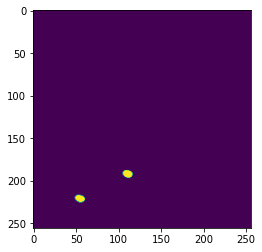

In [36]:
index = 10
plt.imshow(seg_model.predict(train_x)[index])

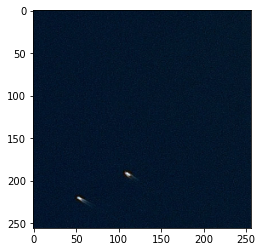

In [37]:
plt.imshow(train_x[index])

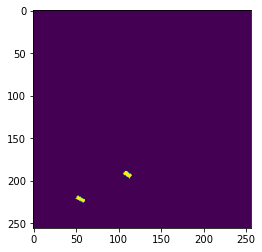

In [38]:
plt.imshow(train_y[index])

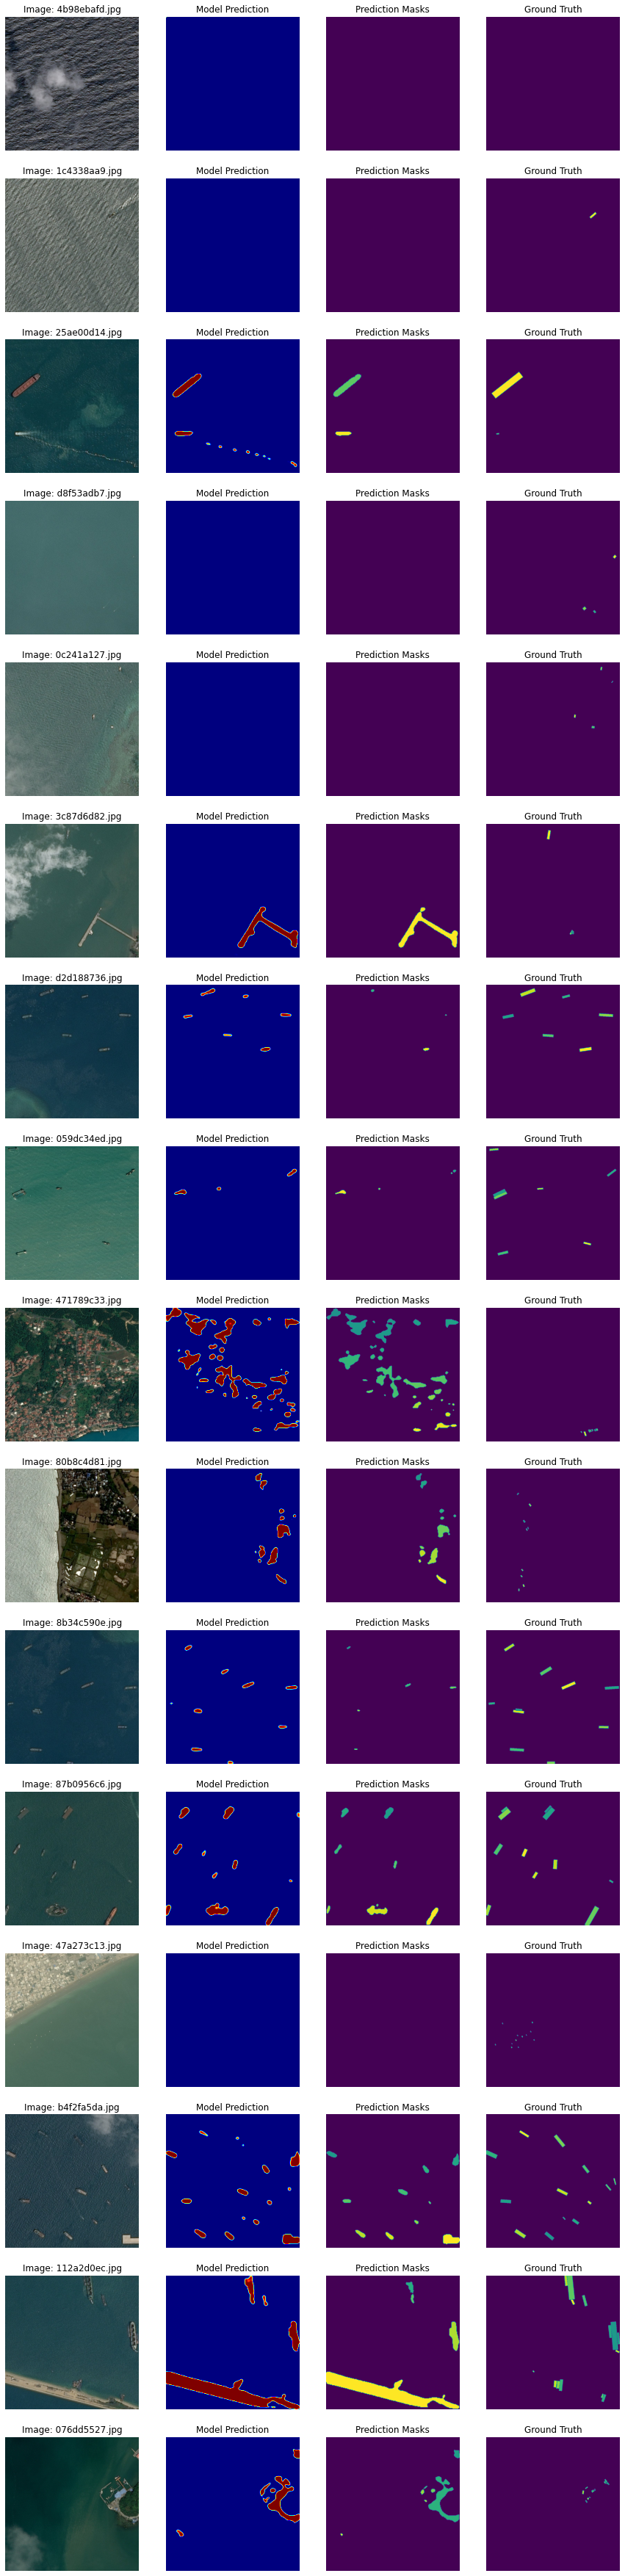

In [39]:

fullres_model = models.Sequential()
fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
fullres_model.add(seg_model)
fullres_model.add(layers.UpSampling2D(IMG_SCALING))
fullres_model.save('fullres_model.h5')
def raw_prediction(img, path='/kaggle/input/airbus-ship-detection/train_v2/'):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path='/kaggle/input/airbus-ship-detection/test_v2/'):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = val_masks.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, '/kaggle/input/airbus-ship-detection/train_v2/')
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = Overlay_masks_col(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = Overlay_masks_col(train_data.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')